# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1870 sha256=b84f67f0733700bb86f71ef5922776642563f4ae2eb93dea71ef497ca586794d
  Stored in directory: /root/.cache/pip/wheels/e3/d2/c9/ba15b05ba596e2eafeb83c2903e79d634207367555aae8c7d2
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import pandas as pd

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

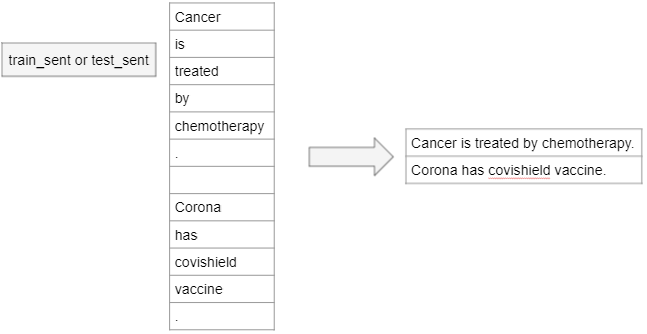

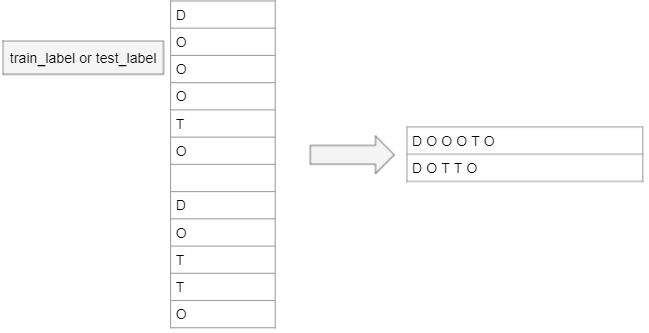

In [17]:
# Reading the files given

with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_words = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_words = test_labels_file.readlines()

In [18]:
print("Token count in training set", len(train_words))
print("Token count in training labels", len(train_labels_words))
print("Token count in test set", len(test_words))
print("Token count in test labels", len(test_labels_words))

Token count in training set 48501
Token count in training labels 48501
Token count in test set 19674
Token count in test labels 19674


In [19]:
# Function to combine tokens belonging to the same sentence. Sentences are separated by "\n" in the dataset.
def convertToSentences(data):
    sent_list = []
    sent = ""
    for entity in data:
        if entity != '\n':
            sent = sent + entity[:-1] + " "       # Adding word/label to current sentence / sequence of labels
        else:
            sent_list.append(sent[:-1])           # Getting rid of the space added after the last entity.
            sent = ""
    return sent_list

In [20]:
TrainSentences = convertToSentences(train_words)

In [21]:
# printing the first 10 TRAIN sentences
for sentence in TrainSentences[:10]:
  print("\n\nTrained Sentence: " + sentence)



Trained Sentence: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


Trained Sentence: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


Trained Sentence: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


Trained Sentence: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )


Trained Sentence: Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


Trained Sentence: Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational ag

In [22]:
# Printing first 10 TEST sentences
TestSentences = convertToSentences(test_words)
for sentence in TestSentences[:10]:
  print("\n\nTest Sentence: " + sentence)



Test Sentence: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


Test Sentence: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


Test Sentence: The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period


Test Sentence: There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )


Test Sentence: Fluctuations in ambient temperature are inversely correlated to changes in AFI


Test Sentence: This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks


Tes

### Count the number of sentences in the processed train and test dataset

In [25]:
print("Sentences count in train dataset", len(TrainSentences))
print("Sentences count in test dataset", len(TestSentences))

Sentences count in train dataset 2599
Sentences count in test dataset 1056


### Count the number of lines of labels in the processed train and test dataset.

In [26]:
train_labels = convertToSentences(train_labels_words)
test_labels = convertToSentences(test_labels_words)

In [27]:
# Printing
print("Sentences count in training labels: ", len(train_labels))
print("Sentences count in test labels: ", len(test_labels))

Sentences count in training labels:  2599
Sentences count in test labels:  1056


# EDA (Exploratroy Data Analysis)

### Sentence Length Distribution (tokens per sentence)

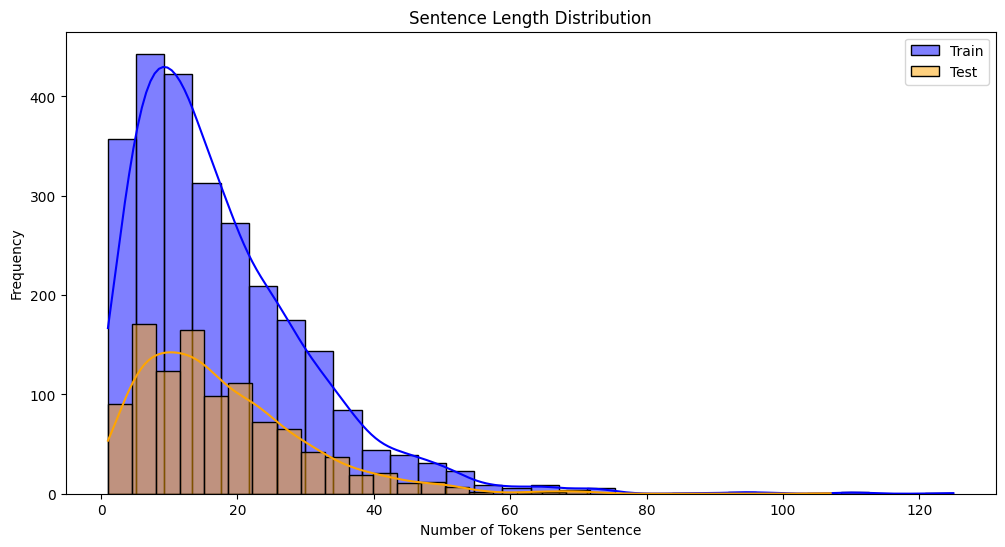

In [29]:


# Compute sentence lengths
train_sent_lengths = [len(sentence.split()) for sentence in TrainSentences]
test_sent_lengths = [len(sentence.split()) for sentence in TestSentences]

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(train_sent_lengths, kde=True, bins=30, color='blue', label='Train')
sns.histplot(test_sent_lengths, kde=True, bins=30, color='orange', label='Test')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Tokens per Sentence")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Description:

1. Majority of Sentences Are Short

- Most sentences in both train and test sets have fewer than 25 tokens.

- This indicates the dataset is dominated by short-form text, which is common in NER, POS tagging, or sequence labeling tasks using sentence-level annotations.

2. Training Set Has More Data

- The blue bars are much taller, indicating a larger number of training sentences than test sentences — good for model learning, as more training data often results in better generalization.

- Skewed Distribution with Long Tails

3. A long tail exists on the right, showing a few very long sentences (some over 3.100 tokens).

- These can create issues during model training (e.g., padding overhead, memory use), so you might consider truncating or batching smartly.

Label Frequency Distribution

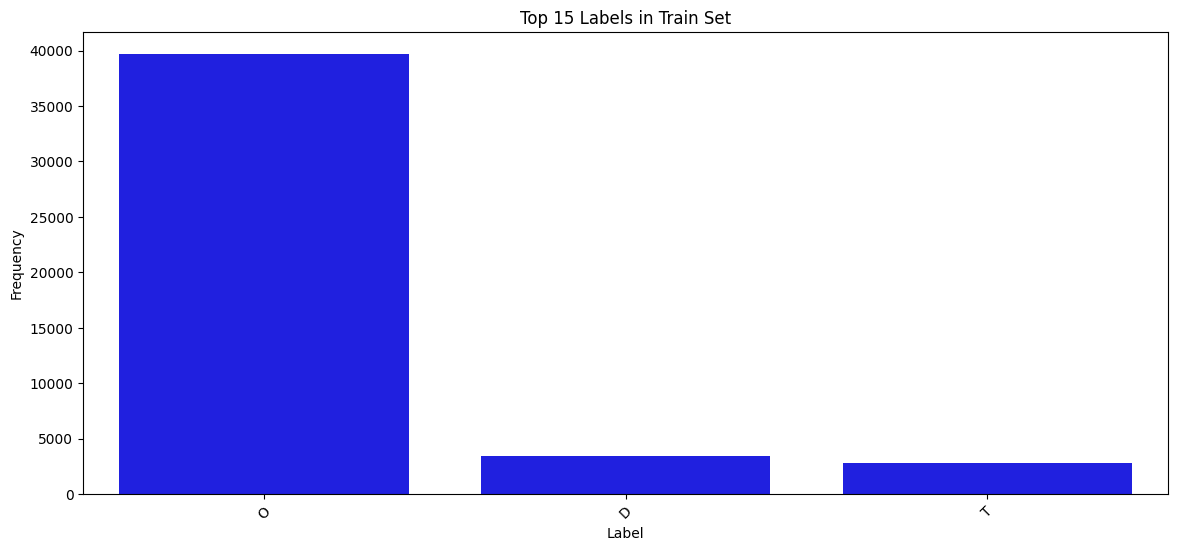

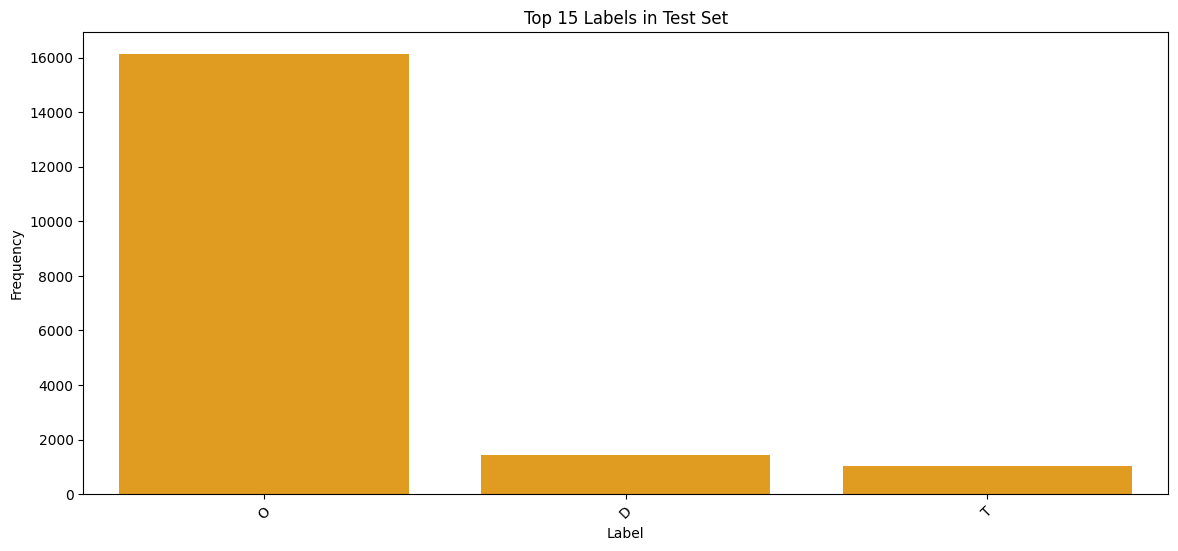

In [32]:
# Flatten label lists
all_train_labels = " ".join(train_labels).split()
all_test_labels = " ".join(test_labels).split()

# Count labels
train_label_counts = Counter(all_train_labels)
test_label_counts = Counter(all_test_labels)

# Plot Top 15 Labels (Train + Test)
plt.figure(figsize=(14, 6))
sns.barplot(x=list(train_label_counts.keys())[:15], y=list(train_label_counts.values())[:15], color='blue')
plt.title("Top 15 Labels in Train Set")
plt.ylabel("Frequency")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=list(test_label_counts.keys())[:15], y=list(test_label_counts.values())[:15], color='orange')
plt.title("Top 15 Labels in Test Set")
plt.ylabel("Frequency")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.show()

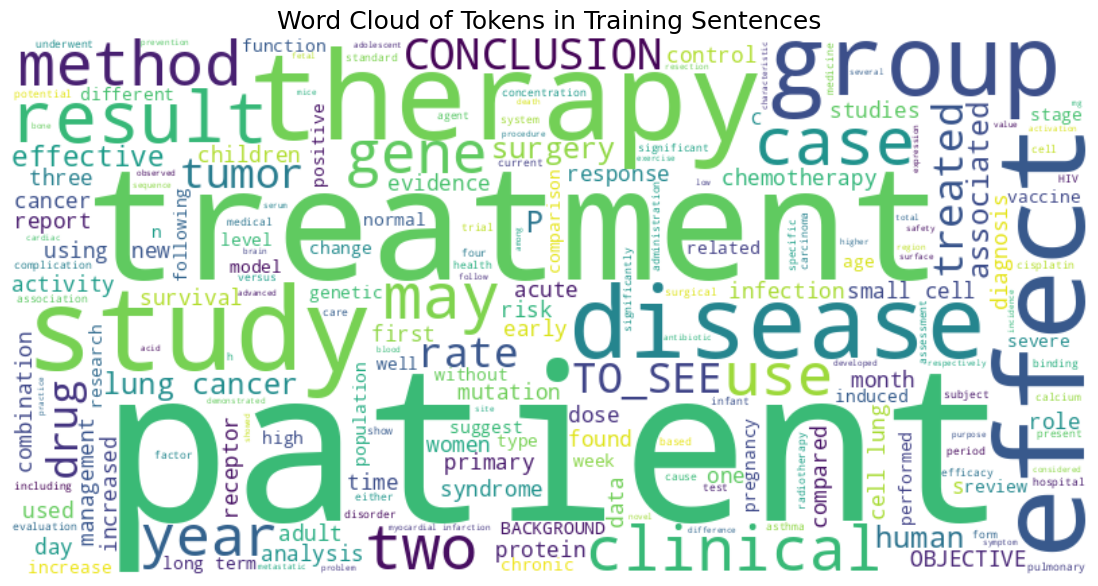

In [110]:
from wordcloud import WordCloud
# All tokens from training set
all_train_tokens = " ".join(TrainSentences)

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_train_tokens)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tokens in Training Sentences", fontsize=18)
plt.show()

Based on the word cloud we can see

1. treatment, patient, therapy, effect, are the major words that appear

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



In [34]:
# Creating a combined dataset from training and test sentnces
total_set = TrainSentences + TestSentences
print("Total number: ", len(total_set))

Total number:  3655


### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [36]:
# Initialize a counter for NOUNs and PROPNs
noun_counter = Counter()

# Process each sentence
for sentence in total_set:
    doc = model(sentence)
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN']:  # Keep only NOUN and PROPER NOUN
            noun_counter[token.text.lower()] += 1  # Count in lowercase for consistency

# Show the top 20 most common NOUNs and PROPER NOUNs
print("Top 20 most common NOUNs and PROPNs:")
for word, freq in noun_counter.most_common(20):
    print(f"{word}: {freq}")

Top 20 most common NOUNs and PROPNs:
patients: 507
treatment: 304
%: 247
cancer: 211
therapy: 177
study: 174
disease: 149
cell: 142
lung: 118
results: 116
group: 111
effects: 99
gene: 91
chemotherapy: 91
use: 87
effect: 82
women: 81
analysis: 76
risk: 74
surgery: 73


In [37]:
# List to store (POS, token) tuples for NOUN and PROPN
noun_tokens = []

# Process each sentence
for sentence in total_set:
    doc = model(sentence)
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN']:
            noun_tokens.append((token.pos_, token.text))

# Print total number of NOUN and PROPN tokens
print("Total number of NOUN and PROPN tokens:", len(noun_tokens))

# Print all POS-tag and token pairs
for pos, token in noun_tokens:
    print(f"{pos}: {token}")

Total number of NOUN and PROPN tokens: 24373
NOUN: births
NOUN: =
NOUN: weeks
PROPN: University
PROPN: Vermont
PROPN: =
NOUN: delivery
NOUN: route
NOUN: indication
NOUN: age
NOUN: parity
NOUN: practice
NOUN: group
NOUN: risk
NOUN: status
NOUN: rate
NOUN: %
NOUN: rate
NOUN: %
NOUN: presentation
NOUN: indication
NOUN: %
NOUN: rate
NOUN: medicine
NOUN: patients
NOUN: %
NOUN: rate
NOUN: %
NOUN: Arrest
NOUN: dilation
NOUN: indication
NOUN: subgroups
NOUN: %
NOUN: rates
NOUN: care
NOUN: hospitals
NOUN: rates
NOUN: community
NOUN: hospitals
NOUN: groups
NOUN: age
NOUN: trimester
NOUN: fluid
NOUN: index
PROPN: AFI
NOUN: fluid
NOUN: status
NOUN: temperature
NOUN: increases
NOUN: decrease
PROPN: AFI
PROPN: June
PROPN: August
NOUN: period
NOUN: heat
NOUN: women
NOUN: singleton
NOUN: pregnancies
NOUN: weeks
NOUN: gestation
NOUN: testing
NOUN: determinations
NOUN: temperature
NOUN: area
NOUN: day
NOUN: temperature
NOUN: test
NOUN: date
PROPN: AFI
PROPN: Spearman
NOUN: rank
NOUN: Correlation
NOUN: r

In [38]:
print("Total number of NOUN and PROPN tokens:", len(noun_tokens))

Total number of NOUN and PROPN tokens: 24373


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [39]:
token_counts = Counter(token.lower() for _, token in noun_tokens)

# Print top 25 most common tokens
print("\nTop 25 most common NOUN/PROPN tokens:")
for token, freq in token_counts.most_common(25):
    print(f"{token}: {freq}")


Top 25 most common NOUN/PROPN tokens:
patients: 507
treatment: 304
%: 247
cancer: 211
therapy: 177
study: 174
disease: 149
cell: 142
lung: 118
results: 116
group: 111
effects: 99
gene: 91
chemotherapy: 91
use: 87
effect: 82
women: 81
analysis: 76
risk: 74
surgery: 73
cases: 72
p: 72
rate: 68
survival: 67
response: 66


## Defining features for CRF





Defining features for CRF
list of features used:

f1 = input word is in lower case;
f2 = last 3 characters of word;
f3 = last 2 characers of word;
f4 = 1; if the word is in uppercase, 0 otherwise;
f5 = 1; if word is a number; otherwise, 0
f6= 1; if the word starts with a capital letter; otherwise, 0
extra feature: if pos > 0 :

fx1 = prev_word to lower
fx2 = prev_word is upper
fx3 = prev_word is digits
fx4 = prev_word starts with capital letter
else:

fx1 = BEG(beginning of text)
if pos reached end:
fx1 = ENd(ending of text)

# MODEL 1: FEATURE

In [41]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [42]:
# Write a code to get features for a sentence.
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [43]:
# Write a code to get the labels for a sentence.
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = TrainSentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False']

In [44]:
sample_sentence = TrainSentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [46]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [48]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in TrainSentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in TestSentences]

### Define the labels as the target variable for test and the train dataset

In [49]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

## Build the CRF Model

In [50]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [61]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [52]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [55]:
metrics.flat_f1_score(y_test, Y_pred, average='weighted')

0.9044158773940202

In [58]:
# Example test sentence and corresponding actual and predicted labels
print("Sentence: ",TestSentences[10])
print("Actual labels:    ", y_test[10])
print("Predicted labels: ", Y_pred[10])

Sentence:  The most common indication leading to diagnosis was abnormal ultrasound finding ( 48.2 % ) , followed by advanced maternal age ( 44.4 % )
Actual labels:     ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [60]:
# Feature list of sentence above
for feature in X_test[10]:
    print(feature)



['word.lower=the', 'word[-3:]=The', 'word[-2:]=he', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'BEG']
['word.lower=most', 'word[-3:]=ost', 'word[-2:]=st', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'prev_word.lower=the', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=True']
['word.lower=common', 'word[-3:]=mon', 'word[-2:]=on', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'prev_word.lower=most', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False']
['word.lower=indication', 'word[-3:]=ion', 'word[-2:]=on', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'prev_word.lower=common', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False']
['word.lower=leading', 'word[-3:]=ing', 'word[-2:]=ng', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=Fa

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

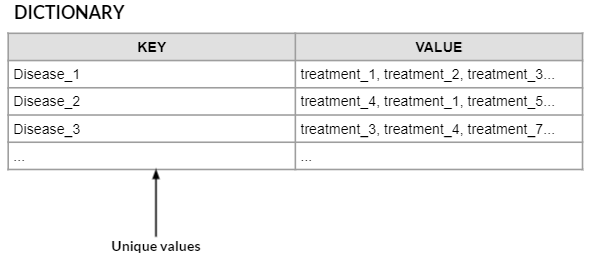

In [64]:
# Dictionary to hold diseases as keys and sets of treatments as values
disease_treatment_dict = defaultdict(set)

# Iterate through the test set
for sentence, labels in zip(X_test, Y_pred):
    current_disease = None
    for features, label in zip(sentence, labels):
        word = features[0].split('=')[1]  # Extract the word from 'word.lower=xxx'

        if label == 'D':
            current_disease = word
        elif label == 'T' and current_disease:
            disease_treatment_dict[current_disease].add(word)

# Convert sets to sorted lists for cleaner display
disease_treatment_dict = {disease: sorted(treatments) for disease, treatments in disease_treatment_dict.items()}

# Print the results
for disease, treatments in disease_treatment_dict.items():
    print(f"{disease}: {', '.join(treatments)}")

retinoblastoma: radiotherapy
cellulitis: antibiotic, intravenous, treatment
): ), and, chemotherapy, cisplatin, donor, insemination, intrauterine, radiotherapy, sperm, versus, with
embolism: hemodynamics, right-side
mesothelioma: ,, and, chemotherapy, radiotherapy, thoracotomy
cancer: adjuvant, amifostine, and, carboplatin, chemotherapy, cisplatin, combination, immediate, intravenous, irradiation, leucovorin, mastectomy, mitoxantrone, or, oxaliplatin, paclitaxel, radiation, reconstruction, resection, subcutaneous, therapy, undergone, with
nsclc: chemoradiotherapy, got, surgical, treatment
sclc: radiotherapy
carcinoma: an, combined-modality, instead, lobectomy, lung, of, open, or, partial, resection, the, therapy, thoracotomy, videothoracoscopic
metastasis: resection, surgical
assessing: ,, and, chemotherapy, cisplatin, combination, ifosfamide, irinotecan, of, rhg-csf, support, with
disease: alone, carboplatin, combination, therapy, with
melanoma: (, a, alfa-2a, interferon, leukocyte, r

In [89]:

dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(Y_pred)):
  p_val = Y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += TestSentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += TestSentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
106,temporomandibular joint arthropathy,arthroscopic treatment
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [90]:
disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


# MODEL 2: PoS Tag in Feature

In [74]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos] # adding POS tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1] # adding POS tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [75]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

In [76]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[2]

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


['word.lower=ambient',
 'word[-3:]=ent',
 'word[-2:]=nt',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'prev_word.lower=the',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=DET']

In [77]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


['word.lower=as',
 'word[-3:]=As',
 'word[-2:]=As',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=SCONJ',
 'BEG']

In [78]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [80]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in TrainSentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in TestSentences]

### Define the labels as target variables for both

In [81]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

Build CRF Model

In [82]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## EVALUATION

In [83]:
Y_pred = crf.predict(X_test)

In [85]:
f1_score = metrics.flat_f1_score(y_test, Y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9073283958612477


In [88]:
# Creating a dataframe for D & T

dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(Y_pred)):
  p_val = Y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += TestSentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += TestSentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
106,temporomandibular joint arthropathy,arthroscopic treatment
107,severe secondary peritonitis,Surgical management
108,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
109,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [92]:
disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


# MODEL 3: Maxiumum Iterations to 300

In [93]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos], # adding POS tag here
    'word.dep_=' + deptags[pos] # adding DEP tag here
    ]

    #Use the previous word also while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # adding POS tag here
        'word.dep_=' + deptags[pos-1] # adding DEP tag here
    ])
    # Mark the begining and the end words of a sentence correctly in the form of features.
    else:
        features.append('BEG') # feature to track begin of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

In [94]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):

    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []

    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep

    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [95]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[2]

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


['word.lower=ambient',
 'word[-3:]=ent',
 'word[-2:]=nt',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=the',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=DET',
 'word.dep_=det']

In [96]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
sample_sentence = train_sentences[1]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[0]

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


['word.lower=as',
 'word[-3:]=As',
 'word[-2:]=As',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=SCONJ',
 'word.dep_=mark',
 'BEG']

In [97]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [98]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in TrainSentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in TestSentences]

### Define the labels as the target variable for test and the train dataset

In [99]:
y_train = [getLabelsInListForOneSentence(label) for label in train_labels]
y_test = [getLabelsInListForOneSentence(label) for label in test_labels]

In [101]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=300)
crf.fit(X_train, y_train)

CRF(max_iterations=300)

## Evaluation

In [104]:
Y_pred = crf.predict(X_test)


In [105]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)


F1 score: 0.9116807612706087


In [107]:
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(y_pred)):
  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += TestSentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += TestSentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,essential hypertension,moxonidine
...,...,...
104,severe secondary peritonitis,Surgical management
105,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
106,chronic renal failure,Epoetin
107,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'


In [108]:

disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


# CONCLUSION

## After running 3 models:

1. 90.04
2. 90.73
3. 91.11

We can say that the 3rd model effectively predicted it correctly.